In [10]:
"""
Python script to generate a synthetic angle gather from a 3-layer property model
to examine pre-stack tuning effects.
Created by:    Wes Hamlyn
Create Date:   19-Aug-2014
Last Mod:      5-Feb-2015
               -addition of bandpass wavelet

This script is provided without warranty of any kind.
"""

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from packages.functions import frm

###########################################################
#
#       FUNCTIONS DEFINITIONS
#





def vshale_from_gr(df):
    """
    Creates Clavier, Larionov old, Larionov new, Steiber VSH
    """    
    GR_min = df.GR.min()
    GR_max = df.GR.max()
    df.loc[:, 'IGR'] = (df.GR - GR_min) / (GR_max - GR_min)
    df.loc[:, 'VSH_clavier'] = 1.7 - ((3.38 - (df.IGR + 0.7)**2)**0.5)
    df.loc[:, 'VSH_larionovO'] = 0.33 * (2**(2*df.IGR)-1)
    df.loc[:, 'VSH_steiber'] = df.IGR / (3 - 2*df.IGR)
    df.loc[:, 'VSH_larionovT'] = 0.083*(2**(3.7*df.IGR)-1)
    # Pick one to be "main" VSH
    df['VSH'] = df.VSH_larionovO
    return df


def vrh(volumes,k,mu):
    f = np.array(volumes).T
    k = np.resize(np.array(k),np.shape(f))
    mu = np.resize(np.array(mu),np.shape(f))

    k_u = np.sum(f*k, axis=1)
    k_l = 1. / np.sum(f/k, axis=1)
    mu_u = np.sum(f*mu, axis=1)
    mu_l = 1. / np.sum(f/mu, axis=1)
    k0 = (k_u+k_l) / 2.
    mu0 = (mu_u+mu_l) / 2.
    return k_u, k_l, mu_u, mu_l, k0, mu0


def plot_vawig(axhdl, data, t, excursion):
    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape

    t = np.hstack([0, t, t.max()])

    for i in range(0, ntrc):
        tbuf = excursion * data[i, :] / np.max(np.abs(data)) + i

        tbuf = np.hstack([i, tbuf, i])

        axhdl.plot(tbuf, t, color='black', linewidth=0.5)
        plt.fill_betweenx(t, tbuf, i, where=tbuf > i, facecolor=[0.6, 0.6, 1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf < i, facecolor=[1.0, 0.7, 0.7], linewidth=0)

    axhdl.set_xlim((-excursion, ntrc + excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()


def ricker(cfreq, phase, dt, wvlt_length):
    """
    Calculate a zero-phase ricker wavelet

    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)

    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    """

    import numpy as np
    import scipy.signal as signal

    nsamp = int(wvlt_length / dt + 1)
    t_max = wvlt_length * 0.5
    t_min = -t_max

    # t = np.arange(t_min, t_max, dt)

    t = np.linspace(-wvlt_length / 2, (wvlt_length - dt) / 2, int(wvlt_length / dt))
    wvlt = (1.0 - 2.0 * (np.pi ** 2) * (cfreq ** 2) * (t ** 2)) * np.exp(-(np.pi ** 2) * (cfreq ** 2) * (t ** 2))

    if phase != 0:
        phase = phase * np.pi / 180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase) * wvlt - np.sin(phase) * wvlth

    return t, wvlt


def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    """
    Calculate a trapezoidal bandpass wavelet

    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)

    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    """

    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift

    nsamp = int(wvlt_length / dt + 1)

    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq * 0.0
    pspec = freq * 0.0

    # Calculate slope and y-int for low frequency ramp
    M1 = 1 / (f2 - f1)
    b1 = -M1 * f1

    # Calculate slop and y-int for high frequency ramp
    M2 = -1 / (f4 - f3)
    b2 = -M2 * f4

    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)

    # Build LF ramp
    idx = np.nonzero((np.abs(freq) >= f1) & (np.abs(freq) < f2))
    filt[idx] = M1 * np.abs(freq)[idx] + b1

    # Build central filter flat
    idx = np.nonzero((np.abs(freq) >= f2) & (np.abs(freq) <= f3))
    filt[idx] = 1.0

    # Build HF ramp
    idx = np.nonzero((np.abs(freq) > f3) & (np.abs(freq) <= f4))
    filt[idx] = M2 * np.abs(freq)[idx] + b2

    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2 * np.exp(np.zeros(filt2.shape) * 1j)

    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt / np.max(np.abs(wvlt))  # normalize wavelet by peak amplitude

    # Generate array of wavelet times
    t = np.linspace(-wvlt_length * 0.5, wvlt_length * 0.5, nsamp)

    # Apply phase rotation if desired
    if phase != 0:
        phase = phase * np.pi / 180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase) * wvlt - np.sin(phase) * wvlth

    return t, wvlt


def calc_times(z_int, vp_mod):
    """
    Calculate two-way travel time through a layered model

    Usage:
    -----
    t_int = calc_times(z_int, vp_mod)

    """

    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i] / vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i] - z_int[i - 1]
            zdiff = zdiff * 2.0  # multiply by 2 for two-way traveltimes
            tbuf = zdiff / vp_mod[i] + t_int[i - 1]
            tbuf = tbuf
            t_int.append(tbuf)

    return t_int


def digitize_model(rc_int, t_int, t):
    """
    Sample a simple layered reflectivity model

    Usage:
    ------
    rc = digitize_model(rc, t_int, t)

    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    """

    import numpy as np

    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)

    rc = list(np.zeros(nsamp, dtype='float'))
    lyr = 0

    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1

        if lyr > nint:
            break

    return rc


def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    """
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.

    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)

    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    """

    import math

    # Cast inputs to floats
    vp1 = float(vp1)
    vp2 = float(vp2)
    vs1 = float(vs1)
    vs2 = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)

    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)  # Convert theta1 to radians
    p = ray_param(vp1, math.degrees(theta1))  # Ray parameter
    theta2 = math.asin(p * vp2);  # Transmission angle of P-wave
    phi1 = math.asin(p * vs1);  # Reflection angle of converted S-wave
    phi2 = math.asin(p * vs2);  # Transmission angle of converted S-wave

    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)], \
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)], \
        [2 * rho1 * vs1 * math.sin(phi1) * math.cos(theta1), rho1 * vs1 * (1 - 2 * math.sin(phi1) ** 2), \
         2 * rho2 * vs2 * math.sin(phi2) * math.cos(theta2), rho2 * vs2 * (1 - 2 * math.sin(phi2) ** 2)], \
        [-rho1 * vp1 * (1 - 2 * math.sin(phi1) ** 2), rho1 * vs1 * math.sin(2 * phi1), \
         rho2 * vp2 * (1 - 2 * math.sin(phi2) ** 2), -rho2 * vs2 * math.sin(2 * phi2)]
    ], dtype='float')

    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)], \
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)], \
        [2 * rho1 * vs1 * math.sin(phi1) * math.cos(theta1), rho1 * vs1 * (1 - 2 * math.sin(phi1) ** 2), \
         2 * rho2 * vs2 * math.sin(phi2) * math.cos(theta2), rho2 * vs2 * (1 - 2 * math.sin(phi2) ** 2)], \
        [rho1 * vp1 * (1 - 2 * math.sin(phi1) ** 2), -rho1 * vs1 * math.sin(2 * phi1), \
         -rho2 * vp2 * (1 - 2 * math.sin(phi2) ** 2), rho2 * vs2 * math.sin(2 * phi2)] \
        ], dtype='float')

    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);

    return R


def ray_param(v, theta):
    """
    Calculates the ray parameter p

    Usage:
    ------
        p = ray_param(v, theta)

    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)

    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    """

    import math

    # Cast inputs to floats
    theta = float(theta)
    v = float(v)

    p = math.sin(math.radians(theta)) / v  # ray parameter calculation

    return p

In [11]:
# if at home, os=windows
path = r"C:\Users\Dunbar\Dropbox\Work\QSI\data"
# path = '/home/alex/Dropbox/Work/QSI/data'
file = '104-1_continuous.csv'

In [12]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine

In [13]:
# loading csv file
cols = ['DEPTH', 'TVD', 'SSTVD', 'Z', 'TWT', 'CALI', 'DEN', 'PEF', 'BS', 'GR', 'NEU', 'ACS', 'AC', 'PHIT', 'PHIE', 'VP',
        'VS', 'Pimp', 'Simp', 'VPVS']
df = pd.read_csv(path + '/' + file, skiprows=2, header=None, na_values=-999.25, names=cols,
                 usecols=['DEPTH', 'TVD', 'SSTVD', 'TWT', 'DEN', 'GR', 'NEU', 'PHIE', 'VP', 'VS', 'Pimp', 'Simp',
                          'VPVS'])

df = vshale_from_gr(df)

In [14]:
formations = ["Tau", "Egersund", "Sandnes", "Bryne", "Triassic", "Zechstein"]
depths = [2215, 2245, 2274, 2311, 2348, 2364]
conditions = [
    (df["DEPTH"].ge(depths[0]) & df["DEPTH"].lt(depths[1])),
    (df["DEPTH"].ge(depths[1]) & df["DEPTH"].lt(depths[2])),
    (df["DEPTH"].ge(depths[2]) & df["DEPTH"].lt(depths[3])),
    (df["DEPTH"].ge(depths[3]) & df["DEPTH"].lt(depths[4])),
    (df["DEPTH"].ge(depths[4]) & df["DEPTH"].lt(depths[5])),
    (df["DEPTH"].ge(depths[5]))
]
df["FORMATION"] = np.select(conditions, formations)

# df = df[(df.FORMATION=='Tau') |
#         (df.FORMATION=='Egersund') |
#         (df.FORMATION=='Sandnes') |
#         (df.FORMATION=='Bryne') |
#         (df.FORMATION=='Triassic') ]

reservoir = [0, 1, 2]
depths = [2215, 2274, 2364, 2377]
conditions = [
    (df["DEPTH"].ge(depths[0]) & df["DEPTH"].lt(depths[1])),
    (df["DEPTH"].ge(depths[1]) & df["DEPTH"].lt(depths[2])),
    (df["DEPTH"].ge(depths[2]) & df["DEPTH"].lt(depths[3]))
]
df["RESERVOIR"] = np.select(conditions, reservoir)

# df = df[df.FORMATION != '0']

df = df[(df.DEPTH >= 2215) & (df.DEPTH < 2370)]
df = df.reset_index(drop=True)
print(df.isnull().sum())

DEPTH            0
TVD              0
SSTVD            0
TWT              0
DEN              0
GR               0
NEU              0
PHIE             0
VP               0
VS               0
Pimp             0
Simp             0
VPVS             0
IGR              0
VSH_clavier      0
VSH_larionovO    0
VSH_steiber      0
VSH_larionovT    0
VSH              0
FORMATION        0
RESERVOIR        0
dtype: int64


In [15]:
RHO_GAS = 0.7;
K_GAS = 0.133
RHO_WATER = 1.055;
K_WATER = 3.013



# 
# shale = df.VSH.values  # 
shale = df.VSH.values

sand = 1 - shale - df.PHIE.values
shaleN = shale / (shale+sand)  # normalized shale and sand volumes
sandN  = sand / (shale+sand)

# mineral mixture bulk and shear moduli, k0 and mu0
k_u, k_l, mu_u, mu_l, k0, mu0 = vrh([shaleN, sandN], [k_sh, k_qz], [mu_sh, mu_qz])

#K0 = k0
df['K0'] = k0

#shale = (df.RESERVOIR != 1)

In [16]:
df.head()

,DEPTH,TVD,SSTVD,TWT,DEN,GR,NEU,PHIE,VP,VS,...,VPVS,IGR,VSH_clavier,VSH_larionovO,VSH_steiber,VSH_larionovT,VSH,FORMATION,RESERVOIR,K0
0,2215.1340,2215.020589,2184.020589,1722.426827,2.3669,103.69,0.3484,0.0268,2733.51,1568.55,...,1.74,0.562628,0.363673,0.389863,0.300110,0.268350,0.389863,Tau,0,25.746615
1,2215.2864,2215.172973,2184.172973,1722.532696,2.3385,102.82,0.3538,0.0227,2718.89,1558.22,...,1.74,0.557662,0.358998,0.384924,0.295892,0.263903,0.384924,Tau,0,25.893662
2,2215.4388,2215.325357,2184.325357,1722.638565,2.3553,104.38,0.3670,0.0231,2714.66,1591.60,...,1.71,0.566568,0.367406,0.393805,0.303486,0.271918,0.393805,Tau,0,25.691875
3,2215.5912,2215.477740,2184.477740,1722.744434,2.4042,102.61,0.3483,0.0076,2712.39,1622.28,...,1.67,0.556463,0.357874,0.383736,0.294881,0.262838,0.383736,Tau,0,26.051642
4,2215.7436,2215.630124,2184.630124,1722.850303,2.4169,95.01,0.3547,0.0045,2732.47,1630.60,...,1.68,0.513074,0.318533,0.342071,0.259935,0.226418,0.342071,Tau,0,27.020972


In [17]:
vpg, vsg, rhog, kg = frm(df.VP, df.VS, df.DEN, RHO_WATER, K_WATER, RHO_GAS, K_GAS, df.K0, df.PHIE)

C:\Users\Dunbar\Dropbox\Work\QSI\packages\functions.py:517: RuntimeWarning: invalid value encountered in double_scalars
  k_s2 = kdry + (1 - (kdry / k0)) ** 2 / ((phi / k_f2) + ((1 - phi) / k0) - (kdry / k0 ** 2))


In [18]:
# vpg = np.array(vpg)
# vsg = np.array(vsg)
# rhog = np.array(rhog)

sand = (df.RESERVOIR == 1)

df['VP_FRMG'] = df.VP
df['VS_FRMG'] = df.VS
df['RHO_FRMG'] = df.DEN

df['VP_FRMG'][sand] = vpg[sand]
df['VS_FRMG'][sand] = vsg[sand]
df['RHO_FRMG'][sand] = rhog[sand]

df['IP_FRMG'] = df.VP_FRMG*df.RHO_FRMG
df['IS_FRMG'] = df.VS_FRMG*df.RHO_FRMG
df['VPVS_FRMG'] = df.VP_FRMG/df.VS_FRMG

# df = df[df.FORMATION == 'Sandnes']

df = df.reset_index(drop=True)

#print(df.head([['VP', 'VS', 'DEN']]))

print(df.isnull().sum())
df.head()

DEPTH            0
TVD              0
SSTVD            0
TWT              0
DEN              0
GR               0
NEU              0
PHIE             0
VP               0
VS               0
Pimp             0
Simp             0
VPVS             0
IGR              0
VSH_clavier      0
VSH_larionovO    0
VSH_steiber      0
VSH_larionovT    0
VSH              0
FORMATION        0
RESERVOIR        0
K0               0
VP_FRMG          0
VS_FRMG          0
RHO_FRMG         0
IP_FRMG          0
IS_FRMG          0
VPVS_FRMG        0
dtype: int64


<ipython-input-18-f379474aa721>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VP_FRMG'][sand] = vpg[sand]
<ipython-input-18-f379474aa721>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VS_FRMG'][sand] = vsg[sand]
<ipython-input-18-f379474aa721>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RHO_FRMG'][sand] = rhog[sand]


,DEPTH,TVD,SSTVD,TWT,DEN,GR,NEU,PHIE,VP,VS,...,VSH,FORMATION,RESERVOIR,K0,VP_FRMG,VS_FRMG,RHO_FRMG,IP_FRMG,IS_FRMG,VPVS_FRMG
0,2215.1340,2215.020589,2184.020589,1722.426827,2.3669,103.69,0.3484,0.0268,2733.51,1568.55,...,0.389863,Tau,0,25.746615,2733.51,1568.55,2.3669,6469.944819,3712.600995,1.742699
1,2215.2864,2215.172973,2184.172973,1722.532696,2.3385,102.82,0.3538,0.0227,2718.89,1558.22,...,0.384924,Tau,0,25.893662,2718.89,1558.22,2.3385,6358.124265,3643.897470,1.744869
2,2215.4388,2215.325357,2184.325357,1722.638565,2.3553,104.38,0.3670,0.0231,2714.66,1591.60,...,0.393805,Tau,0,25.691875,2714.66,1591.60,2.3553,6393.838698,3748.695480,1.705617
3,2215.5912,2215.477740,2184.477740,1722.744434,2.4042,102.61,0.3483,0.0076,2712.39,1622.28,...,0.383736,Tau,0,26.051642,2712.39,1622.28,2.4042,6521.128038,3900.285576,1.671962
4,2215.7436,2215.630124,2184.630124,1722.850303,2.4169,95.01,0.3547,0.0045,2732.47,1630.60,...,0.342071,Tau,0,27.020972,2732.47,1630.60,2.4169,6604.106743,3940.997140,1.675745


In [19]:
###########################################################
#
#       DEFINE MODELING PARAMETERS HERE
#

vp_mod = list(df.VP)
vs_mod = list(df.VS)
rho_mod = list(df.DEN)
# vp_mod = list(df.VP_FRMG)
# vs_mod = list(df.VS_FRMG)
# rho_mod = list(df.RHO_FRMG)
z_int = list(df.DEPTH)#[:-1])
twt_mod = list(df.TWT/1000)

#   Angle range for incident rays
theta1_min = 0.0  # best to leave this set to zero
theta1_max = 40.0
theta1_step = 1.0

#   Wavelet Parameters
wvlt_type = 'bandpass'  # Valid values: 'ricker' or 'bandpass'
# wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length = 0.128  # Wavelet length in seconds
wvlt_phase = 0.0  # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 = 5.0  # Bandpass wavelet low truncation frequency
f2 = 10.0  # Bandpass wavelet low cut frequency
f3 = 60.0  # Bandpass wavelet high cut frequency
f4 = 75.0  # Bandpass wavelet high truncation frequency

#   Trace Parameters
tmin = 0.0
tmax = 2.0
dt = 0.00001  # changing this from 0.0001 can affect the display quality

#   Plotting Display Parameters
min_plot_time = 1.7
max_plot_time = 1.9
excursion = 2

In [20]:
##########################################################
#
#       COMPUTATIONS HAPPEN BELOW HERE
#


#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int((theta1_max - theta1_min) / theta1_step + 1)

#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

rows, cols = (nangles, len(vp_mod) - 1)
rc_zoep_pp = [[0] * cols] * rows

theta1 = []
for i in range(0, nangles):
    theta1_buf = i * theta1_step + theta1_min
    rc_zoep_pp_tmp = []
    for j in range(0, len(vp_mod) - 1):
        rc_buf = rc_zoep(vp_mod[j], vs_mod[j], rho_mod[j], vp_mod[j + 1], vs_mod[j + 1], rho_mod[j + 1], theta1_buf)
        rc_zoep_pp_tmp.append(rc_buf[0, 0])
    rc_zoep_pp[i] = (rc_zoep_pp_tmp)

In [21]:
#   Define time sample vector for output model & traces
nsamp = int((tmax - tmin) / dt) + 1
t = []
for i in range(0, nsamp):
    t.append(i * dt)

syn_zoep_pp = []
lyr_times = []
print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    # p = ray_param(vp_mod[0], angle)
    # angle2 = math.degrees(math.asin(p*vp_mod[1]))
    # dz_app = thickness/math.cos(math.radians(angle2))

    #   Calculate interface times
    #t_int = calc_times(z_int, vp_mod)
    t_int = twt_mod[:-1]
    # Traceback (most recent call last):
    #  line 459, in <module>
    # lines.append(syn_zoep_pp[j, idx[j]])
    # IndexError: index 20433 is out of bounds for axis 1 with size 20001
    lyr_times.append(t_int)

    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    # print("Calculated angle %i" % (angle))



Starting synthetic calcuations...



In [32]:
t_int[:5], t[:5]

([1.72242682705078,
  1.7225326959375,
  1.7226385648242202,
  1.72274443371094,
  1.72285030259766],
 array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05]))

In [25]:
np.max(rc), np.min(rc)

(0.1061821363016224, -0.08892409373901457)

In [26]:
#    Convert data arrays from lists/tuples to numpy arrays
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)

#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times / dt), dtype='int32')

In [27]:
lyr_times.shape
print(lyr_times[40][:5])
print(len(lyr_times[0]))
print(twt_mod[:5])
print(len(twt_mod))
print(t_int[:5])
print(lyr_indx[0][:5])
print(len(lyr_indx[0]))
print(len(set(lyr_indx[0])))

[1.72242683 1.7225327  1.72263856 1.72274443 1.7228503 ]
1016
[1.72242682705078, 1.7225326959375, 1.7226385648242202, 1.72274443371094, 1.72285030259766]
1017
[1.72242682705078, 1.7225326959375, 1.7226385648242202, 1.72274443371094, 1.72285030259766]
[172243 172253 172264 172274 172285]
1016
1016


In [28]:
lyr_indicies = []
for i in range(0, nint):
    lyr_indicies.append(lyr_indx[:, i])

[ntrc, nsamp] = syn_zoep_pp.shape  # eg: 41 traces, 5001 samples

lines = []
for i in range(0, nint):
    idx = lyr_indx[:, i]
    for j in range(0, 41):
        lines.append(syn_zoep_pp[j, idx[j]])

lines = np.reshape(np.array(lines), (nint, nangles))

In [29]:
#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:, 0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(lines[0])
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc, 1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc))) ** 2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

print('\n\n')
print('  Method       NI         GRAD')
print('---------------------------------')
print(' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
print(' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))




  Method       NI         GRAD
---------------------------------
 Zoeppritz   -0.00864     0.01244
 Convolved  -0.00177    -0.02934


In [30]:
#   Create a "digital" time domain version of the input property model for
#   easy plotting and comparison with the time synthetic traces

print(f"t.shape: {t.shape}")
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)

for i in range(0, nlayers):
    if i == 0:
        vp_dig[0:lyr_indicies[i][0]] = vp_mod[i]
    if 0 < i < nint:
        vp_dig[lyr_indicies[i - 1][0]:lyr_indicies[i][0]] = vp_mod[i]
    vp_dig[lyr_indicies[i - 1][0]:] = vp_mod[i]

for i in range(0, nlayers):
    if i == 0:
        vs_dig[0:lyr_indicies[i][0]] = vs_mod[i]
    if 0 < i < nint:
        vs_dig[lyr_indicies[i - 1][0]:lyr_indicies[i][0]] = vs_mod[i]
    vs_dig[lyr_indicies[i - 1][0]:] = vs_mod[i]

for i in range(0, nlayers):
    if i == 0:
        rho_dig[0:lyr_indicies[i][0]] = rho_mod[i]
    if 0 < i < nint:
        rho_dig[lyr_indicies[i - 1][0]:lyr_indicies[i][0]] = rho_mod[i]
    rho_dig[lyr_indicies[i - 1][0]:] = rho_mod[i]

t.shape: (200000,)


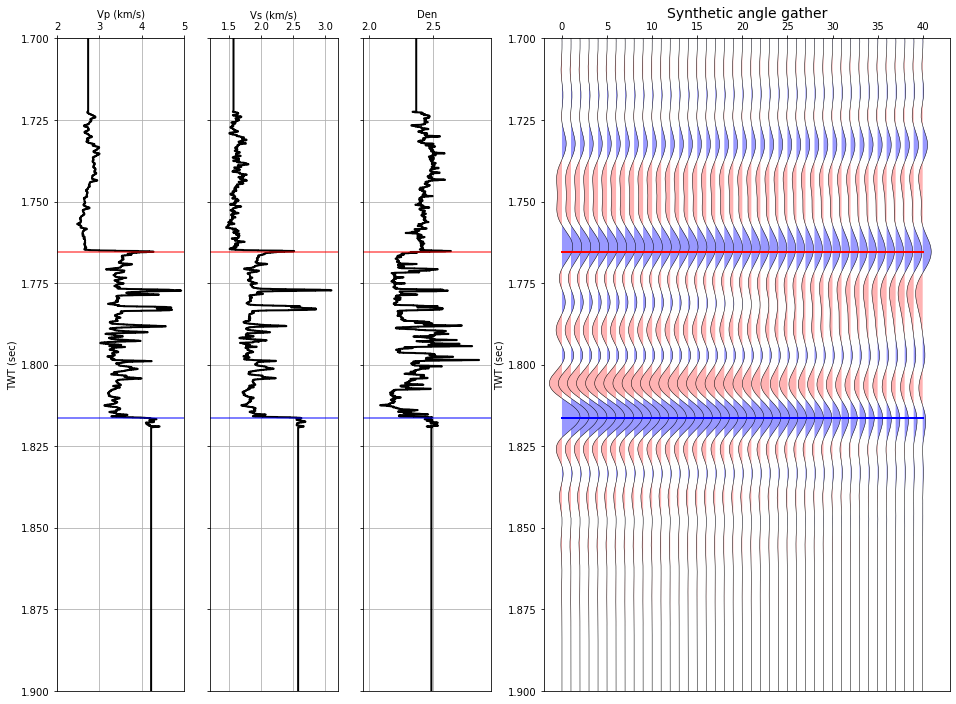

In [31]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')

#   Plot log curves in two-way time
ax0a = fig.add_subplot(161)
l_vp_dig, = ax0a.plot(vp_dig / 1000, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time, max_plot_time))
ax0a.set_xlim(2.0, 5.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('TWT (sec)')
ax0a.xaxis.tick_top()
ax0a.xaxis.set_label_position('top')
ax0a.set_xlabel('Vp (km/s)')
ax0a.axhline(lyr_times[0, 980], color='blue', lw=2, alpha=0.5)
ax0a.axhline(lyr_times[0, 393], color='red', lw=2, alpha=0.5)
ax0a.grid()

ax0b = fig.add_subplot(162)
l_vs_dig, = ax0b.plot(vs_dig / 1000, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time, max_plot_time))
ax0b.set_xlim(1.2, 3.2)
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('Vs (km/s)')
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0, 980], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0, 393], color='red', lw=2, alpha=0.5)
ax0b.grid()

ax0c = fig.add_subplot(163)
l_rho_dig, = ax0c.plot(rho_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time, max_plot_time))
ax0c.set_xlim(1.95, 2.95)
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel('Den')
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0, 980], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0, 393], color='red', lw=2, alpha=0.5)
ax0c.grid()


#   Plot synthetic gather and model top & base interfaces in two-way time
ax1 = fig.add_subplot(122)
plot_vawig(ax1, syn_zoep_pp, t, excursion)
ax1.set_ylim((min_plot_time, max_plot_time))
l_int1, = ax1.plot(lyr_times[:, 980], color='blue', lw=2)
l_int2, = ax1.plot(lyr_times[:, 393], color='red', lw=2)

# plt.legend([l_int1, l_int2], ['Interface 1', 'Interface 2'], loc=4)
ax1.invert_yaxis()
label_str = 'Synthetic angle gather'
ax1.set_xlabel(label_str, fontsize=14)
ax1.set_ylabel('TWT (sec)')



#   Save the plot
plt.savefig('figure_2.png')

#   Display the plot
plt.show()